In [1]:
import sys
import os
import numpy as np
import pickle as pkl
from sklearn import decomposition, ensemble, model_selection, cluster
from matplotlib import pyplot as plt
import pandas as pd 
import h5py
import glob
import re

cwd = os.getcwd()
cwd = cwd[: -(1 + len(cwd.split("/")[-1]))] + "/neuronencodings"
sys.path.append(cwd)

HOME = os.path.expanduser("~")

/usr/people/nturner/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load predictions

In [2]:
folder_path = "{}/seungmount/research/nick_and_sven/models_nick/p100_dend_outer/inference/".format(HOME)

In [3]:
pred_paths = glob.glob(folder_path + "/*.h5")

In [4]:
cell_vertices = []
cell_ids = []

for path in pred_paths:
    with h5py.File(path, "r") as f:
        cell_vertices.append(f["vertices"].value)
        cell_ids.append(int(re.findall("[\d]+", os.path.basename(path))[0]))

## Postprocessing

In [5]:
def hist_1d(arr):
    return np.histogram(arr / arr.max(), bins=np.linspace(0, 1, 11))[0]

def feat_stats(arr):
    return np.concatenate([np.mean(arr, axis=0),
                           np.median(arr, axis=0),
                           np.var(arr, axis=0)])

def combine_predictions(vertices, use_hist=False):
    vertices = np.array(vertices).copy()
    
    feats = feat_stats(vertices)
    
    if use_hist:
        hist = np.apply_along_axis(hist_1d, axis=1, arr=vertices)
        all_feats = np.concatenate([feat_stats(hist), feats])

    return feats

One to turn on and off: histogram features. 

In [6]:
features = []
for i_cell in range(len(pred_paths)):
    features.append(combine_predictions(cell_vertices[i_cell], use_hist=True))

## Visualization

In [7]:
cm = plt.get_cmap('tab10')
colors = [cm(.05 + .1 * i) for i in range(10)]

In [8]:
def pca_plot(preds, labels, n_components=10, plot_axis=[[0, 1], [2, 3]]):
    preds = np.array(preds)

    features_n = preds.copy()
    std = np.std(features_n, axis=0)[None]
    std[std == 0] = 1
    features_n /= std
    features_n -= np.nanmean(features_n, axis=0)[None]

    pca = decomposition.PCA(n_components=n_components)
    features_t = pca.fit_transform(features_n)

    u_labels = np.unique(labels)

    for axis in plot_axis:
        plt.figure(figsize=(10, 10))

        for i_label, u_label in enumerate(u_labels):
            m = labels == u_label
            plt.scatter(features_t[m, axis[0]], features_t[m, axis[1]], alpha=.7, c=colors[i_label])

        plt.xlabel("PC %d" % (axis[0] + 1), fontsize=16)
        plt.ylabel("PC %d" % (axis[1] + 1), fontsize=16)

        plt.show()
        
    return features_t

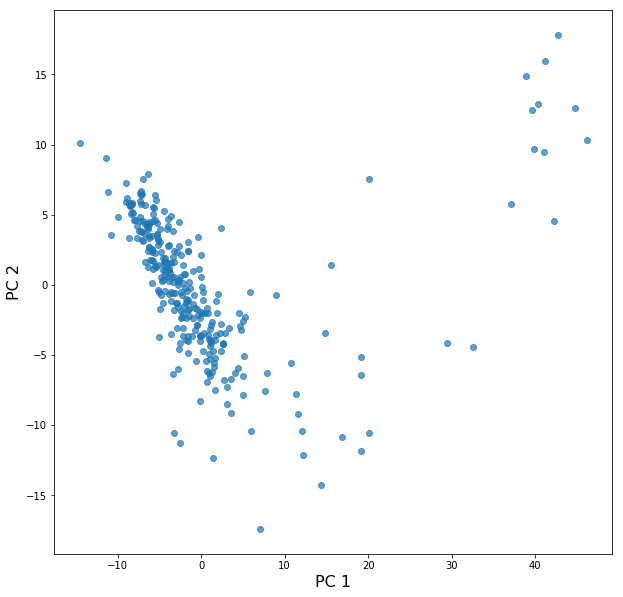

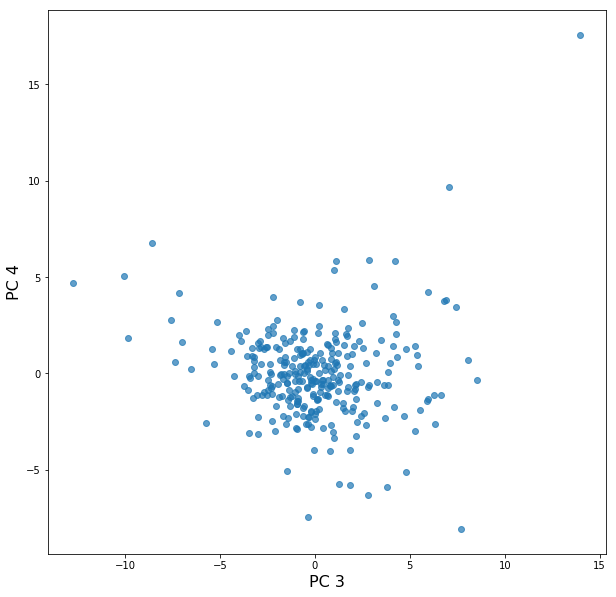

In [9]:
features_t = pca_plot(features, np.zeros(len(cell_ids), dtype=np.int))

## Save features

In [10]:
for i_cell in range(len(cell_ids)):
    cell_id = cell_ids[i_cell]
    
    path = "{}/{}_pca_features.h5".format(folder_path, cell_id)
    
    with h5py.File(path, "w") as f:
        f.create_dataset("features", data=features_t[i_cell])